In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import pickle
from tqdm import tqdm
from scipy.spatial import KDTree


In [2]:
import os
df = pd.read_csv('/Users/medinils/Desktop/IMC_Spatial_predictions/data/processed_data/df.csv')


/var/folders/nb/7f6f4ycn50538pmqf470flx0ncxrsr/T/ipykernel_18656/578141671.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/medinils/Desktop/IMC_Spatial_predictions/data/processed_data/df.csv')


In [9]:
from scipy.spatial import cKDTree
import pandas as pd
import networkx as nx

In [43]:
import numpy as np
import pandas as pd
import networkx as nx
import pickle
from scipy.spatial import KDTree
from tqdm import tqdm


# Create a smaller subset for testing (1% of the data)
subset = df.sample(frac=0.01, random_state=42)

# Group data by 'Patient ID'
grouped = subset.groupby('Patient ID')

# Patient ID for the test
test_patient_id = 'MB-0002'

# Create graphs dictionary
patient_graphs = {}
for patient_id, data in grouped:
    if patient_id == test_patient_id:
        G = nx.Graph()
        positions = {}
        node_list = []

        # Agregar nodos al grafo y almacenar sus coordenadas para el KD-Tree
        for index, row in data.iterrows():
            node_id = index  # O cualquier identificador único para el nodo
            node_list.append(node_id)
            coords = (row['Location_Center_X'], row['Location_Center_Y'])
            positions[node_id] = coords
            G.add_node(node_id, CD68=row['CD68'], CD3=row['CD3'], CD20=row['CD20'], coords=coords)

        # Crear KD-Tree a partir de las posiciones de los nodos
        kd_tree = KDTree(list(positions.values()))

        # Consultar el KD-Tree para vecinos dentro de una distancia de 30 unidades
        for node_id in tqdm(node_list, desc=f"Processing nodes for patient {patient_id}"):
            pos = positions[node_id]
            distances, indices = kd_tree.query(pos, k=len(data), distance_upper_bound=15)
            for dist, idx in zip(distances, indices):
                if dist != np.inf and node_id != node_list[idx]:
                    G.add_edge(node_id, node_list[idx], weight=dist)

        # Guardar el grafo para este paciente
        patient_graphs[patient_id] = G


Processing nodes for patient MB-0002: 100%|██████████| 12445/12445 [00:35<00:00, 349.30it/s]


In [44]:
# Suponiendo que tienes el patient_id como 'MB-0000'
patient_id = 'MB-0002'

# Acceder al grafo del paciente específico
graph = patient_graphs.get(patient_id)

if graph:
    print(f"Accediendo al grafo del paciente {patient_id}:")
    print("Número de nodos:", graph.number_of_nodes())
    print("Número de aristas:", graph.number_of_edges())
    # Mostrar más detalles si necesitas
else:
    print(f"No se encontró un grafo para el paciente {patient_id}.")


Accediendo al grafo del paciente MB-0002:
Número de nodos: 12445
Número de aristas: 420363


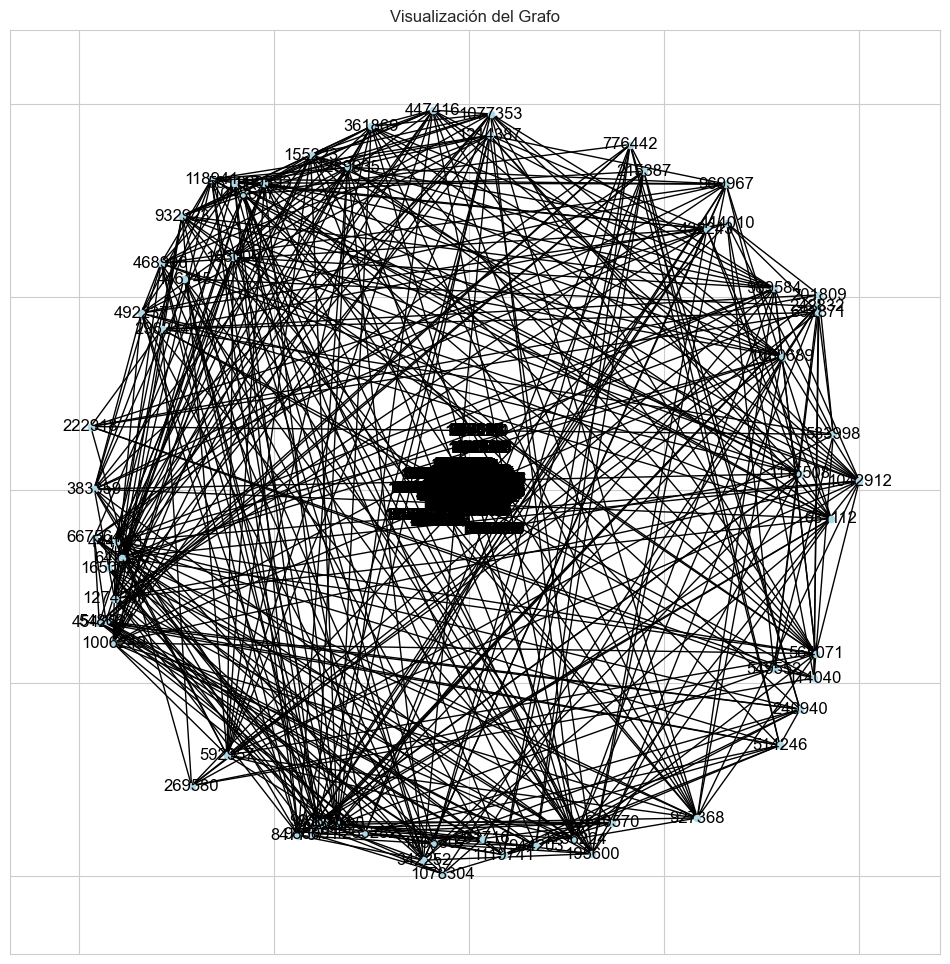

In [45]:
import matplotlib.pyplot as plt
import networkx as nx

G = graph  # Asegúrate de que 'graph' está definido como tu objeto de grafo
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_size=20, node_color='lightblue')
plt.title("Visualización del Grafo")
plt.show()


In [49]:
# Asumiendo que tu grafo se llama G
node_attributes = G.nodes[776442]  # Reemplaza '1' con el ID real del nodo si es diferente
print("Atributos del nodo 1:", node_attributes)


Atributos del nodo 1: {'CD68': -0.6426509643917054, 'CD3': -0.5629459274587556, 'CD20': -0.7875543355495596, 'coords': (175.92308, 387.10257)}


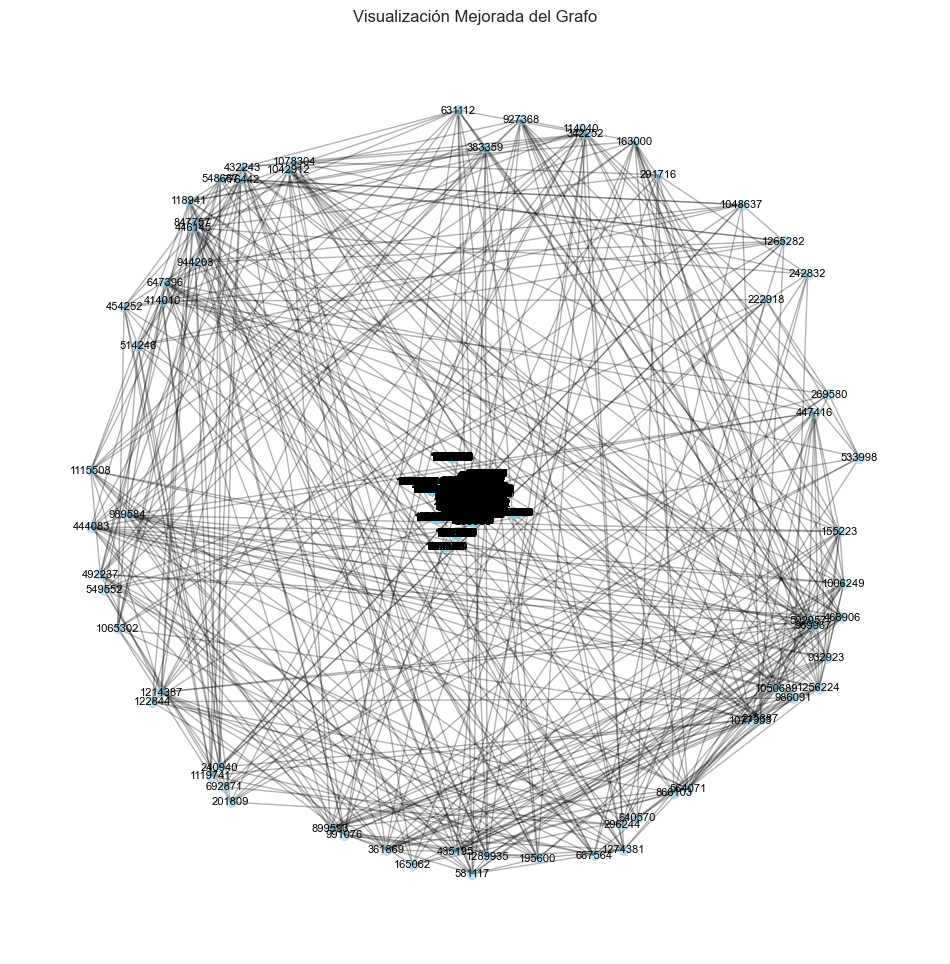

In [50]:
import matplotlib.pyplot as plt
import networkx as nx

# Asumimos que 'G' es tu grafo
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, scale=2)  # Puedes probar con 'kamada_kawai_layout', 'circular_layout'

# Dibuja el grafo con ajustes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue', alpha=0.5)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

plt.title("Visualización Mejorada del Grafo")
plt.axis('off')  # Oculta los ejes
plt.show()


In [5]:
#####ALL THE GRAPHS
import numpy as np
import pandas as pd
import networkx as nx
import pickle
from scipy.spatial import KDTree
from tqdm import tqdm

# Create a smaller subset for testing
subset = df.sample(frac=0.00001, random_state=42)

# Group data by 'Patient ID'
grouped = subset.groupby('Patient ID')

# Create graphs dictionary
patient_graphs = {}
for patient_id, data in tqdm(grouped, desc="Processing patients"):
    G = nx.Graph()
    positions = {}
    node_list = []

    # Add nodes to the graph and store their coordinates for the KD-Tree
    for index, row in data.iterrows():
        node_id = index  # Or any unique identifier for the node
        node_list.append(node_id)
        coords = (row['Location_Center_X'], row['Location_Center_Y'])
        positions[node_id] = coords
        G.add_node(node_id, CD68=row['CD68'], CD3=row['CD3'], CD20=row['CD20'], coords=coords)

    # Only create a KD-Tree if there are enough nodes to justify its use
    if len(positions) > 1:
        kd_tree = KDTree(list(positions.values()))
        # Query the KD-Tree for neighbors within a distance of 15 units
        for node_id in tqdm(node_list, desc=f"Processing nodes for patient {patient_id}"):
            pos = positions[node_id]
            distances, indices = kd_tree.query(pos, k=len(data), distance_upper_bound=15)
            # Ensure distances and indices are iterable (i.e., arrays)
            if np.isscalar(distances):
                distances = [distances]
                indices = [indices]
            for dist, idx in zip(distances, indices):
                if dist != np.inf and node_id != node_list[idx]:
                    G.add_edge(node_id, node_list[idx], weight=dist)
    elif len(positions) == 1:
        # Handle the case with one node where no edges can be created
        node_id = node_list[0]
        # Correcting the addition of node with explicit keyword arguments for attributes
        G.add_node(node_id, CD68=data.iloc[0]['CD68'], CD3=data.iloc[0]['CD3'], CD20=data.iloc[0]['CD20'], coords=positions[node_id])

    # Save the graph for this patient
    patient_graphs[patient_id] = G




Processing nodes for patient MB-0000: 100%|██████████| 2/2 [00:00<00:00, 2919.81it/s]

Processing nodes for patient MB-0002: 100%|██████████| 12/12 [00:00<00:00, 7322.03it/s]

Processing nodes for patient MB-0005: 100%|██████████| 15/15 [00:00<00:00, 5142.60it/s]

Processing nodes for patient MB-0010: 100%|██████████| 13/13 [00:00<00:00, 12057.93it/s]

Processing nodes for patient MB-0014: 100%|██████████| 27/27 [00:00<00:00, 7929.30it/s]

Processing nodes for patient MB-0022: 100%|██████████| 2/2 [00:00<00:00, 3044.87it/s]

Processing nodes for patient MB-0028: 100%|██████████| 10/10 [00:00<00:00, 7496.52it/s]

Processing nodes for patient MB-0035: 100%|██████████| 13/13 [00:00<00:00, 12151.98it/s]

Processing nodes for patient MB-0045: 100%|██████████| 15/15 [00:00<00:00, 7808.68it/s]

Processing nodes for patient MB-0050: 100%|██████████| 13/13 [00:00<00:00, 3271.88it/s]

Processing nodes for patient MB-0060: 100%|██████████| 46/46 [00:00<00:00, 9103.42it/s]

Processing nodes for pa

In [ ]:
# Save graphs to a file
with open("./results/graphs/patient_graphs.pkl", "wb") as f:
    pickle.dump(patient_graphs, f)